In [1]:
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.2-py3-none-any.whl size=190289 sha256=d44657c7e47fde3391fd41e0bc9a506b054b2a4b6c5b3134e9d663e20644497e
  Stored in directory: /root/.cache/pip/wheels/81/1b/61/aa85b78c3c0c8871f4231e3f4a03bb23cecb7db829498380ee
Successfully built pyod


In [2]:
!pip install combo

  Preparing metadata (setup.py) ... done
  Created wheel for combo: filename=combo-0.1.3-py3-none-any.whl size=42860 sha256=d70691c2111d60873740740149951f4b0507d16caf33ad5ee571bfc7fe820acf
  Stored in directory: /root/.cache/pip/wheels/7a/48/ff/0d6e1017d8bf3d844d332736fbb268dca767162779f93ff50a
Successfully built combo


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

In [11]:
def generate_data(n_train=100, n_test=50, n_features=2, contamination=0.1):
    # Generating a dataset for a classification problem
    X, y = make_classification(n_samples=n_train + n_test, n_features=n_features,
                               flip_y=contamination, n_informative=n_features,
                               n_redundant=0, n_clusters_per_class=1)

    return X[:n_train], y[:n_train], X[n_train:], y[n_train:]

In [15]:
# Generate the data with given parameters
contamination = 0.1 # percentage of outliers
n_train = 500       # number of training points
n_test = 500        # number of testing points
n_features = 2      # number of features
X_train, y_train, X_test, y_test = generate_data(n_train=n_train, n_test=n_test,
                                                 n_features=n_features, contamination=contamination)
# Check the shapes of X_train and y_train
X_train_shape = X_train.shape
y_train_shape = y_train.shape

X_train_shape, y_train_shape


((500, 2), (500,))

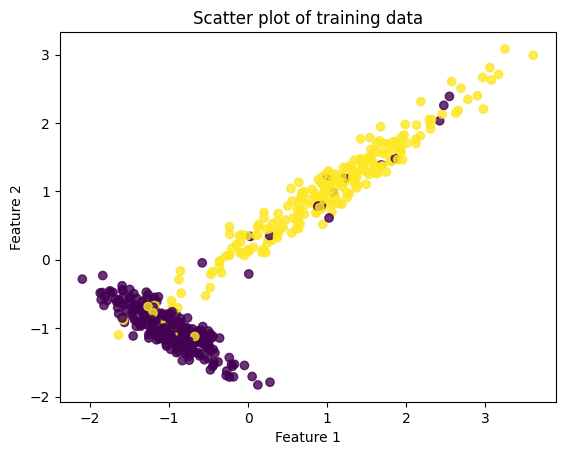

In [14]:
# Plotting the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, alpha=0.8)
plt.title('Scatter plot of training data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

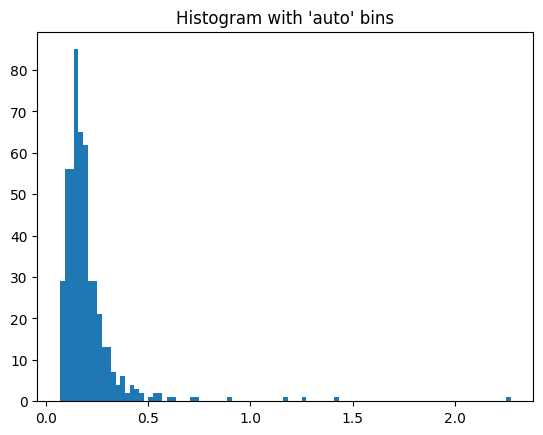

In [16]:
from pyod.models.knn import KNN
clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)
# If you want to see the predictions of the training data, you can use this way:
y_train_scores = clf.decision_scores_
plt.hist(y_train_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

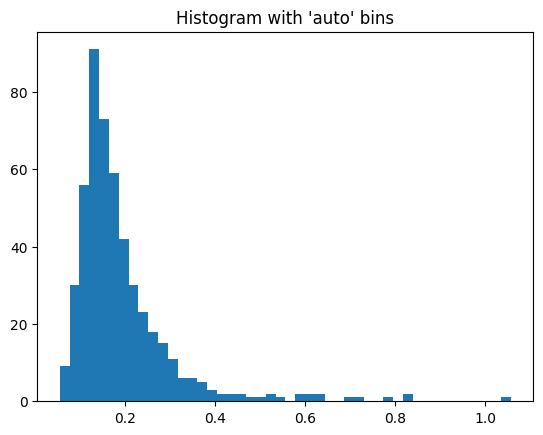

In [17]:
# Now we have the trained K-NN model, let's apply to the test data to get the predictions
y_test_pred = clf.predict(X_test) # outlier labels (0 or 1)
# Because it is '0' and '1', we can run a count statistic. There are 44 '1's and 456 '0's. The number of anomalies is roughly ten percent, as we have generated before:
unique, counts = np.unique(y_test_pred, return_counts=True)
dict(zip(unique, counts))
#{0: 456, 1: 44}
# And you can generate the anomaly score using clf.decision_function:
y_test_scores = clf.decision_function(X_test)
plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [19]:
# Let's see how many '0's and '1's. We get 452 '0's and 48 '1's.
df_test = pd.DataFrame(X_test)
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<1, 0, 1)
df_test['cluster'].value_counts()
# Now let's show the summary statistics:
#df_test.groupby('y_by_average_cluster').mean()
df_test.groupby('cluster').mean()

,0,1,score
cluster,,,
0,1.007144,-0.000903,0.191906
1,-2.392486,1.396940,1.056255


In [20]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)
# Test a range of k-neighbors from 10 to 200. There will be 20 k-NN models.
n_clf = 20
k_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,
 120, 130, 140, 150, 160, 170, 180, 190, 200]
# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])
train_scores.shape
# Modeling
for i in range(n_clf):
    k = k_list[i]
    clf = KNN(n_neighbors=k, method='largest')
    clf.fit(X_train_norm)

    # Store the results in each column:
    train_scores[:, i] = clf.decision_scores_
    test_scores[:, i] = clf.decision_function(X_test_norm)
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

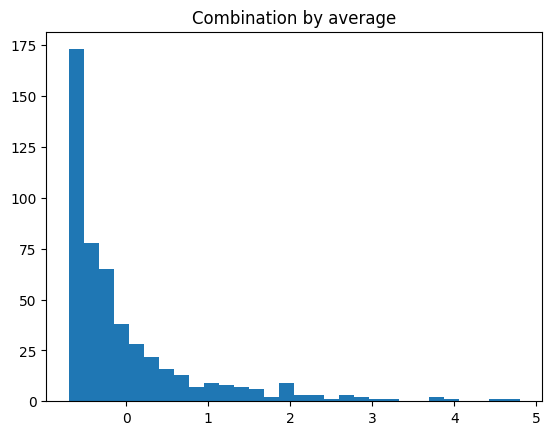

In [21]:
y_by_average = average(test_scores_norm)
import matplotlib.pyplot as plt
plt.hist(y_by_average, bins='auto') # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()


In [22]:
df_test = pd.DataFrame(X_test)
df_test['y_by_average_score'] = y_by_average
df_test['y_by_average_cluster'] = np.where(df_test['y_by_average_score']<0, 0, 1)
df_test['y_by_average_cluster'].value_counts()

0    350
1    150
Name: y_by_average_cluster, dtype: int64

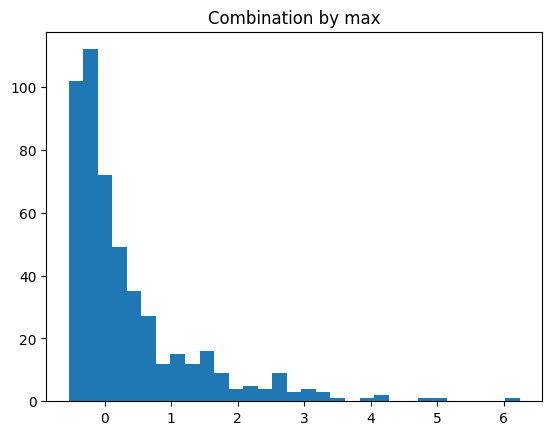

In [23]:
y_by_maximization = maximization(test_scores_norm)

import matplotlib.pyplot as plt
plt.hist(y_by_maximization, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.show()

In [24]:
df_test = pd.DataFrame(X_test)
df_test['y_by_maximization_score'] = y_by_maximization
df_test['y_by_maximization_cluster'] = np.where(df_test['y_by_maximization_score']<0, 0, 1)
df_test['y_by_maximization_cluster'].value_counts()

0    251
1    249
Name: y_by_maximization_cluster, dtype: int64

In [25]:
df_test.groupby('y_by_maximization_cluster').mean()

,0,1,y_by_maximization_score
y_by_maximization_cluster,,,
0,0.753071,0.100329,-0.272229
1,1.249605,-0.097336,0.970843


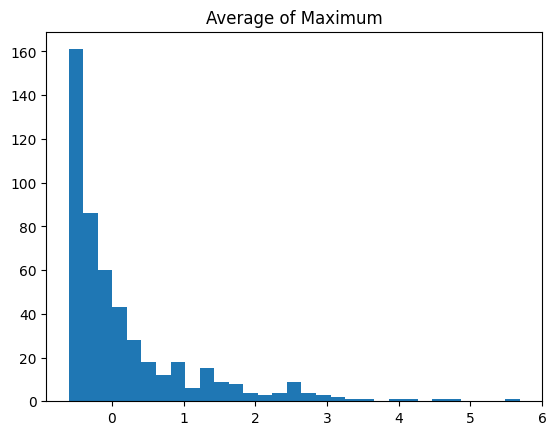

In [26]:
y_by_aom = aom(test_scores_norm, n_buckets=5)

import matplotlib.pyplot as plt
plt.hist(y_by_aom, bins='auto')  # arguments are passed to np.histogram
plt.title("Average of Maximum")
plt.show()

In [27]:
df_test = pd.DataFrame(X_test)
df_test['y_by_aom_score'] = y_by_aom
df_test['y_by_aom_cluster'] = np.where(df_test['y_by_aom_score']<0, 0, 1)
df_test['y_by_aom_cluster'].value_counts()

0    306
1    194
Name: y_by_aom_cluster, dtype: int64

In [28]:
df_test.groupby('y_by_aom_cluster').mean()

,0,1,y_by_aom_score
y_by_aom_cluster,,,
0,0.786723,0.114634,-0.361949
1,1.337296,-0.175938,1.047489


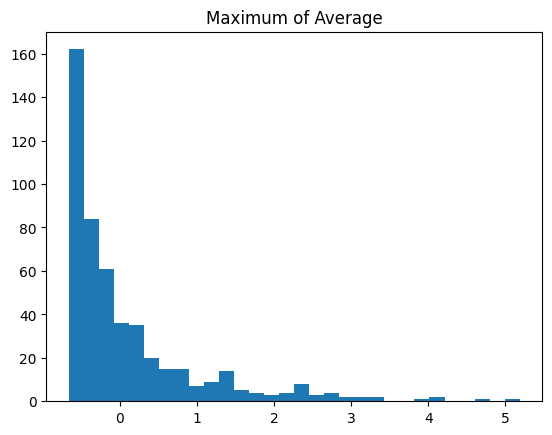

In [29]:
y_by_moa = moa(test_scores_norm, n_buckets=5)

import matplotlib.pyplot as plt
plt.hist(y_by_moa, bins='auto')  # arguments are passed to np.histogram
plt.title("Maximum of Average")
plt.show()

In [30]:
df_test = pd.DataFrame(X_test)
df_test['y_by_moa_score'] = y_by_moa
df_test['y_by_moa_cluster'] = np.where(df_test['y_by_moa_score']<0, 0, 1)
df_test['y_by_moa_cluster'].value_counts()

0    325
1    175
Name: y_by_moa_cluster, dtype: int64

In [31]:
df_test.groupby('y_by_moa_cluster').mean()

,0,1,y_by_moa_score
y_by_moa_cluster,,,
0,0.809694,0.106683,-0.413810
1,1.354411,-0.192719,1.036254


In [32]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
samples = X_train[0:5]
samples

array([[ 1.0221091 , -1.42096113],
       [ 1.18474691,  1.30246213],
       [ 0.62178319, -0.72350264],
       [-0.19231549, -0.6268967 ],
       [ 1.7249738 ,  0.55203411]])

In [33]:
my_knn = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(samples)
distances, indices = my_knn.kneighbors(samples, return_distance=True)
distances

array([[0.        , 0.80418231],
       [0.        , 0.92465523],
       [0.        , 0.80418231],
       [0.        , 0.81981057],
       [0.        , 0.92465523]])

In [34]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(samples)
kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([1, 0, 1, 1, 0], dtype=int32)

In [35]:
centroids = kmeans.cluster_centers_
centroids

array([[ 1.45486036,  0.92724812],
       [ 0.48385894, -0.92378682]])